# Tensor Decomposition
We aim to solve $\min_{u_1,\cdots,u_m} \Vert \sum_{i=1}^{r}c_iz_i^{\otimes l}-\sum_{i=1}^{m}u_i^{\otimes l}\Vert_F^2$ in this file.

In [1]:
import torch
import torch.nn

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-paper')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 150

# Import TensorLy+
import tensorly as tl

tl.set_backend('pytorch')

device = 'mps' # mac m1
# device = 'cpu'


def T_calculate(r, C, Z, l):
    # C: [1, r]
    # Z: [d, r]
    d, r = Z.size()

    a = Z[:, 0].reshape(d)
    res = a
    for _ in range(l - 1):
        res = torch.tensordot(a, res, dims=0)

    res *= C[0]

    for i in range(1, r):
        a = Z[:, i].reshape(d)
        b = a
        for _ in range(l - 1):
            b = torch.tensordot(a, b, dims=0)
        res += b * C[i]

    return res

In [20]:
r = 4
l = 4
d = 10
m = 10

Z = torch.nn.utils.parametrizations.orthogonal(torch.nn.Linear(r, d)).weight
print((torch.dot(Z[:, 0], Z[:, 0]).detach().numpy())**l)
C = torch.Tensor([10, 5, 3, 1])
alpha = 2e-2 # initialization size
num_iter = 500000
# U = torch.ones(d, k)
U = alpha * torch.normal(0, 1, size=(d, m))
print(U.shape)
eta = 0.001

# C: [1, r]
# Z: [d, r]
# U: [d, m]
d, r = Z.size()
d, m = U.size()

U = torch.nn.parameter.Parameter(data=U, requires_grad=True)
optimizer = torch.optim.SGD([U], lr=eta, momentum=0.0)
errors = []

signal1s = []
signal2s = []
signal3s = []
signal4s = []

for i in range(1, num_iter):
    optimizer.zero_grad()
    signal1, signal2, signal3, signal4 = 0, 0, 0, 0
    for j in range(m):
        signal1 += (torch.dot(Z[:, 0], U[:, j]).detach().numpy())**l
        signal2 += (torch.dot(Z[:, 1], U[:, j]).detach().numpy())**l
        signal3 += (torch.dot(Z[:, 2], U[:, j]).detach().numpy())**l
        signal4 += (torch.dot(Z[:, 3], U[:, j]).detach().numpy())**l

    signal1s.append(signal1)
    signal2s.append(signal2)
    signal3s.append(signal3)
    signal4s.append(signal4)
    T_target = T_calculate(r=r, C=C, Z=Z, l=l)
    T = T_calculate(r=m, C=torch.ones(m), Z=U, l=l)

    loss = tl.norm(T_target - T, 2)**2

    loss.backward(retain_graph=True)
    optimizer.step()
    error = tl.norm(T_target.data - T.data, 2) / tl.norm(T_target.data, 2)
    errors.append(error)
    if i % 1000 == 0:
        print("Epoch {},. Relative error: {}".format(i, error))


1.0
torch.Size([10, 10])
Epoch 1000,. Relative error: 0.9999986290931702
Epoch 2000,. Relative error: 0.9999971985816956
Epoch 3000,. Relative error: 0.9999917149543762
Epoch 4000,. Relative error: 0.5091654062271118
Epoch 5000,. Relative error: 0.5082828402519226
Epoch 6000,. Relative error: 0.27216488122940063
Epoch 7000,. Relative error: 0.27216485142707825
Epoch 8000,. Relative error: 0.2721647620201111
Epoch 9000,. Relative error: 0.2721646726131439
Epoch 10000,. Relative error: 0.27216458320617676
Epoch 11000,. Relative error: 0.2721644937992096
Epoch 12000,. Relative error: 0.27216437458992004
Epoch 13000,. Relative error: 0.2721641957759857
Epoch 14000,. Relative error: 0.2721640467643738
Epoch 15000,. Relative error: 0.27216386795043945
Epoch 16000,. Relative error: 0.2721635401248932
Epoch 17000,. Relative error: 0.2721632122993469
Epoch 18000,. Relative error: 0.2721627354621887
Epoch 19000,. Relative error: 0.2721620202064514
Epoch 20000,. Relative error: 0.2721610367298126

KeyboardInterrupt: 

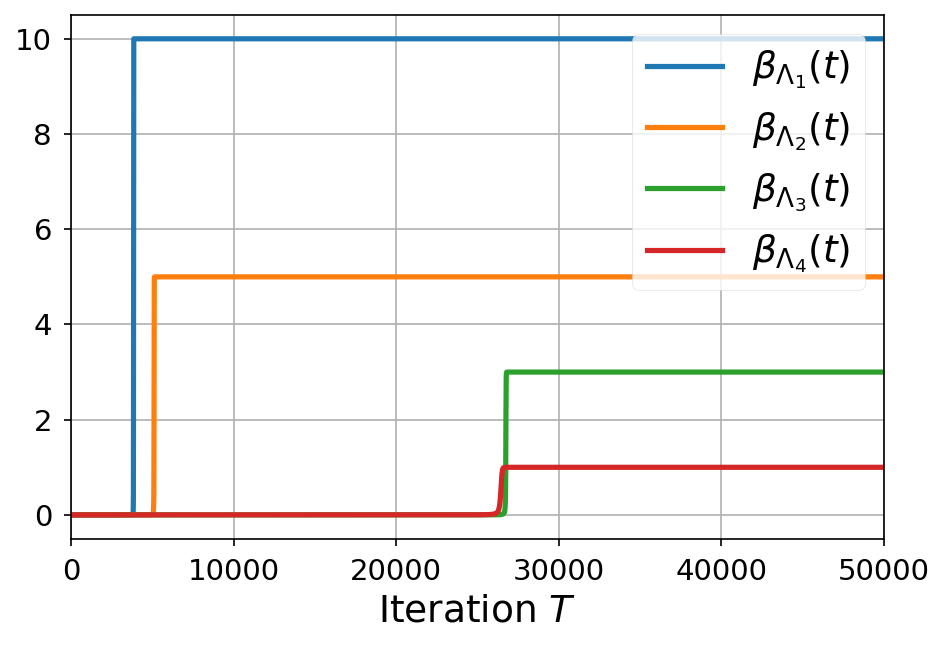

In [27]:
plt.plot(signal1s, linewidth=2.5, label='$\\beta_{\Lambda_1}(t)$')
plt.plot(signal2s, linewidth=2.5, label='$\\beta_{\Lambda_2}(t)$')
plt.plot(signal3s, linewidth=2.5, label='$\\beta_{\Lambda_3}(t)$')
plt.plot(signal4s, linewidth=2.5, label='$\\beta_{\Lambda_4}(t)$')
plt.xlim(0, 50000)
plt.xlabel("Iteration $T$", color='k')
plt.legend(loc='upper right', prop={'size': 18})
axes = plt.gca()
axes.xaxis.label.set_size(18)
axes.yaxis.label.set_size(18)
plt.xticks(color='k', fontsize=14)
plt.yticks(color='k', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('tensor')

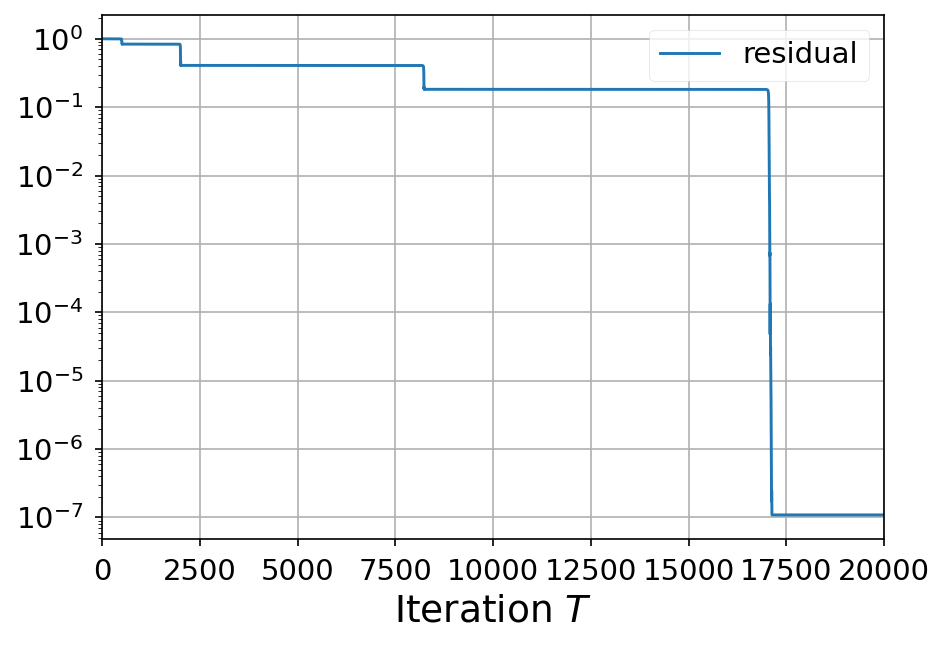

In [10]:
# m = 4, alpha = 0.02
plt.plot(errors, label='residual')
plt.yscale('log')
plt.xlim(0, 20000)
plt.xlabel("Iteration $T$", color='k')
plt.legend(loc='best', prop={'size': 14})
axes = plt.gca()
axes.xaxis.label.set_size(18)
axes.yaxis.label.set_size(18)
plt.xticks(color='k', fontsize=14)
plt.yticks(color='k', fontsize=14)
plt.grid(True)
plt.tight_layout()